# 프로젝트 : 개선된 U-Net 모델 만들기

2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다.  
https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20

![deeper8_detec_unetp](../image/deeper8_detec_unetp.png)

## KITTI 데이터셋 수집과 구축

다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(          # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

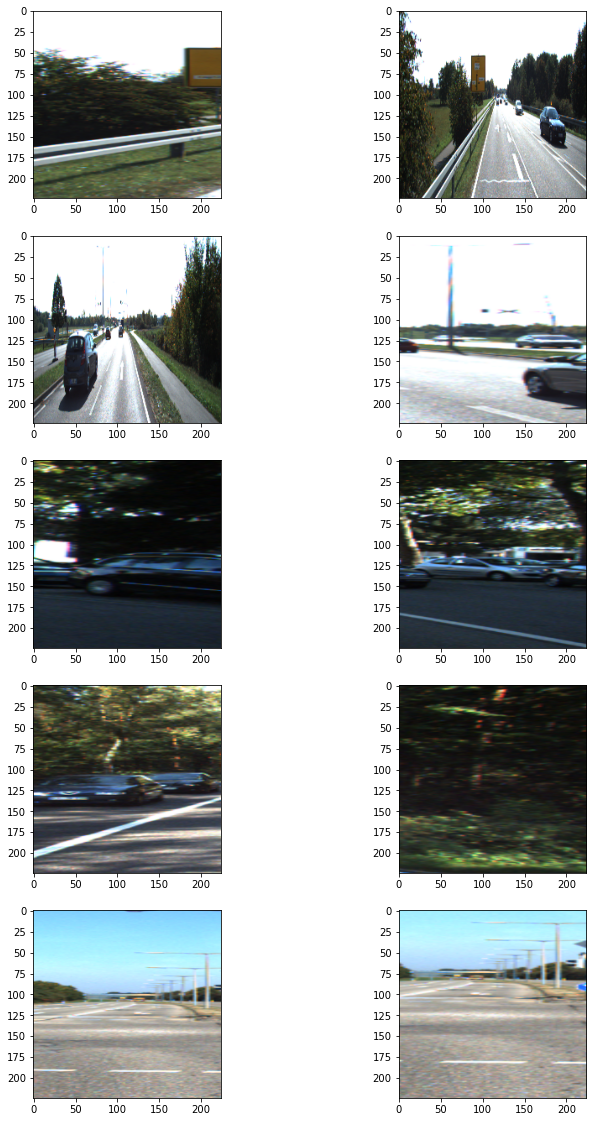

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=1,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## U-Net 모델

In [6]:
def build_unet(input_shape=(224, 224, 3)):
    # input_shape에 따라 U-Net을 만들어주세요. 이때 model은 fully convolutional해야 합니다.
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    # Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
model_unet = build_unet()

In [8]:
model_unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [9]:
model_unet.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model_unet.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_path = dir_path + '/seg_model_unet.h5'
model_unet.save(unet_path)  # 학습한 모델을 저장해 주세요.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
170/170 [==============================] - 11s 63ms/step - loss: 0.4366 - val_loss: 0.3216
Epoch 2/100
170/170 [==============================] - 11s 66ms/step - loss: 0.3000 - val_loss: 0.3163
Epoch 3/100
170/170 [==============================] - 11s 64ms/step - loss: 0.3017 - val_loss: 0.4098
Epoch 4/100
170/170 [==============================] - 11s 66ms/step - loss: 0.2776 - val_loss: 0.2585
Epoch 5/100
170/170 [==============================] - 11s 66ms/step - loss: 0.2137 - val_loss: 0.2636
Epoch 6/100
170/170 [==============================] - 11s 66ms/step - loss: 0.1923 - val_loss: 0.2964
Epoch 7/100
170/170 [==============================] - 11s 66ms/step - loss: 0.1847 - val_loss: 0.2645
Epoch 8/100
170/170 [==============================] - 11s 66ms/step - loss: 0.2138 - val_loss: 0.2930
Epoch 9/100
170/170 [==============================] - 11s 66ms/step - loss: 0.2027 - val_loss: 0.32

170/170 [==============================] - 11s 65ms/step - loss: 0.0786 - val_loss: 0.1699
Epoch 76/100
170/170 [==============================] - 11s 65ms/step - loss: 0.0868 - val_loss: 0.1758
Epoch 77/100
170/170 [==============================] - 11s 65ms/step - loss: 0.0788 - val_loss: 0.2496
Epoch 78/100
170/170 [==============================] - 11s 65ms/step - loss: 0.0943 - val_loss: 0.2237
Epoch 79/100
170/170 [==============================] - 11s 65ms/step - loss: 0.1116 - val_loss: 0.1617
Epoch 80/100
170/170 [==============================] - 11s 65ms/step - loss: 0.0915 - val_loss: 0.2796
Epoch 81/100
170/170 [==============================] - 11s 65ms/step - loss: 0.0955 - val_loss: 0.2088
Epoch 82/100
170/170 [==============================] - 11s 65ms/step - loss: 0.0902 - val_loss: 0.1918
Epoch 83/100
170/170 [==============================] - 11s 65ms/step - loss: 0.0904 - val_loss: 0.2300
Epoch 84/100
170/170 [==============================] - 11s 65ms/step - loss:

In [10]:
aaa

NameError: name 'aaa' is not defined

## U-Net++ 모델의 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.
그 외 적절히 U-Net의 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.

In [6]:

def unet_plus2(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    
    # down

    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3_0)  
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_0)
    
    ## extaracing path ##
    # up1
    
    up1_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_0)) 
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3) # x0_1
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1) ## x0_1 con result
        
    up2_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_0))
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3) # 
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1) ## 
        
    up3_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_0))
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3) #
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
        
    # up2
    
    up1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_1)) 
    merge0_2 = concatenate([conv0_0, up1_1, conv0_1], axis = 3) #
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
        
    up2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    merge1_2 = concatenate([conv1_0, up2_1, conv1_0], axis = 3) #
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
     
    # up3
    
    up1_2 = Conv2D(64,3, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_2)) 
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3) #
    conv0_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
    
    ## main upsampling ## 
    
    up4_0 = Conv2D(512,3, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_0))
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3) #
    conv3_1 = Conv2D(512,3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_1)
    
    up3_1 = Conv2D(256,3, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3) #
    conv2_2 = Conv2D(256,3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    
    up2_2 = Conv2D(512,3, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_2], axis = 3) #
    conv1_3 = Conv2D(512,3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    
    up1_3 = Conv2D(1024,3, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_3))
    merge0_4 = concatenate([conv0_0, up1_3, conv0_1, conv0_2, conv0_3], axis = 3) #
    conv0_4 = Conv2D(1024,3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_4)
    
    conv_fin = Conv2D(1, 1, activation='sigmoid')(conv0_4)

    model = Model(inputs = inputs, outputs = conv_fin)
    return model
    
    
    

In [7]:
model_unetplus2 = unet_plus2()

In [8]:
model_unetplus2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
model_unetplus2.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model_unetplus2.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

In [10]:
unet_plus2_path = dir_path + '/seg_model_unet_plus2.h5'
model_unetplus2.save(unet_plus2_path)  # 학습한 모델을 저장해 주세요.

## U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

In [ ]:
## model_unet, model_unetplus2

두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

In [72]:
unet_path = dir_path + '/seg_model_unet.h5'
unet_plus2p_path = dir_path + '/seg_model_unet_plus2.h5'

unet = tf.keras.models.load_model(unet_path)
unet_plus2 = tf.keras.models.load_model(unet_plus2p_path)

* 시각화

In [73]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

* IOU

In [74]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

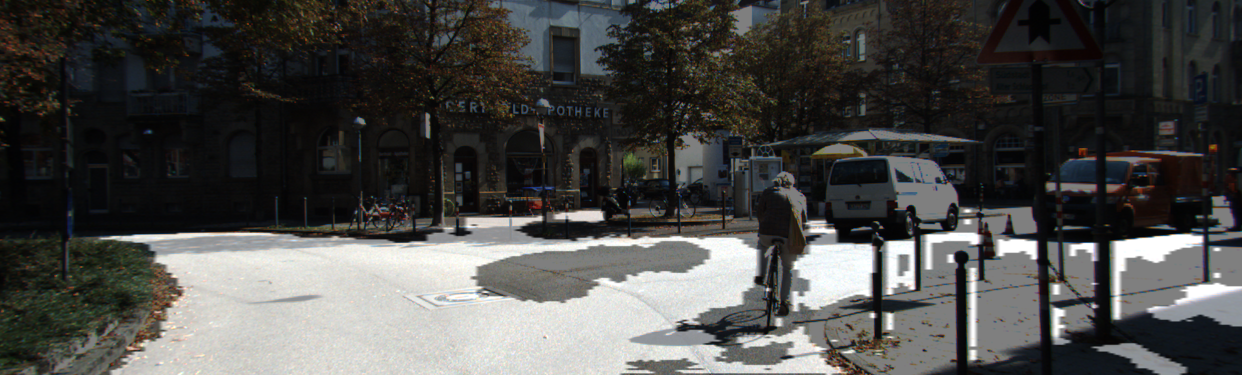

In [82]:
# U-Net 추론 결과 시각화
i = 3    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

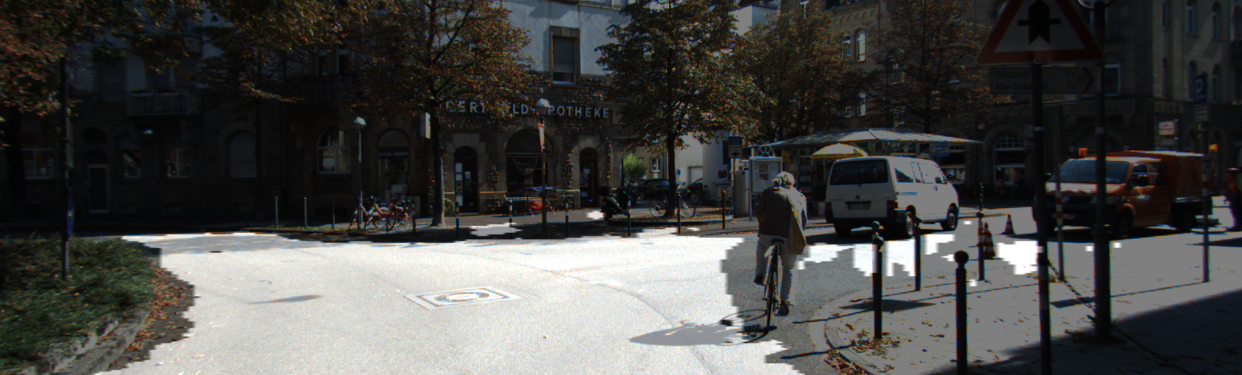

In [83]:
# U-Net++ 추론 결과 시각화
get_output(
     unet_plus2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

```UNET과 Plus 모두 도로를 잘 구분하는 것이 아닌 도로의 일부분만 파악하는 수준에 그쳤다. 그러나 plus가 도로영역을 더 많이 감지해내는 결과를 나타냈다.
 plus로 변하면서 파라미터가 약 2000만개 증가했는데, 맞게 모델이 설계된것인지 모르겠으나 결과는 수고로움에 비해 생각보다 좋지 않았다.```